<a href="https://colab.research.google.com/github/Keval1998/cudaProject/blob/master/HistoEqualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-xqcrxk8s
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-xqcrxk8s
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4307 sha256=002ba8bcd936df9b8c24c8df17f86b9236a48d458925d43e92d5f10e0aa36759
  Stored in directory: /tmp/pip-ephem-wheel-cache-u9qk9d4j/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [ ]:
%%cu
#include<cstdlib>
#include<iostream>
using namespace std;
#include<cuda.h>
#include<stdio.h>

__global__ void histogramKernel(int *data,int *bins,long long int N, int N_bins)
{
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(tid<N)
	{
		atomicAdd(&bins[data[tid]],1);
	}
}

__global__ void histogramKernelShared(int *data,int *bins,long long int N, int N_bins, float *binsnew)
{
	extern __shared__ int s_bins[];
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(threadIdx.x < N_bins)s_bins[threadIdx.x]=0;
	__syncthreads();
	if(tid<N)
	{
		atomicAdd(&s_bins[data[tid]],1);
	__syncthreads();
		if(threadIdx.x < N_bins)
	{
			atomicAdd(&bins[threadIdx.x],s_bins[threadIdx.x]);
		__syncthreads();
		__shared__ float s_binsnew[256];
        s_binsnew[threadIdx.x]=0.00;
       for(int i=0;i<=threadIdx.x;i++) s_binsnew[threadIdx.x]+=bins[i];
      __syncthreads();
       s_binsnew[threadIdx.x]=round((s_binsnew[threadIdx.x]/N)*N_bins-1);
			__syncthreads();
       if (s_binsnew[threadIdx.x]>N_bins-1)s_binsnew[threadIdx.x]=N_bins-1;
      __syncthreads();
		binsnew[threadIdx.x] = s_binsnew[threadIdx.x];
	}
	}
}

__global__ void mapHistogram(int *data,long long int N,float *binsnew)
{
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(tid<N)data[tid]=binsnew[data[tid]];
}

void init_array(int *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_arrayf(float *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_long_array(int *a,long long int N,int N_bins)
{
	for(int i=0;i<N;i++)a[i]=rand()%N_bins;
}

void histogram(int *arr, int *bins, long long int N)
{
	for (long long int i=0;i<N;i++)
	{
		bins[arr[i]]++;
	}
}

void print_arr(int *arr, int N)
{
	for (int i=0;i<N;i++)
	{
		//if(arr[i]!=0)
			cout<<i<<"->"<<arr[i]<<endl;
	}
	cout<<endl;
}

void print_arrf(float *arr, int N)
{
	for (int i=0;i<N;i++)
	{
		cout<<i<<"->"<<arr[i]<<endl;
	}
	cout<<endl;
}


void print_long_arr(int *arr,long long int N)
{
	for (int i=0;i<N;i++)
	{
		cout<<arr[i]<<" ";
	}
	cout<<endl;
}

void printSum(int *arr,int N)
{
	long long int sum=0;
	for(int i=0;i<N;i++)sum+=arr[i];
	cout<<"Verification of total is: " << sum<<endl;
}

void printSumf(float *arr,int N)
{
	float sum=0.0;
	for(int i=0;i<N;i++)sum+=arr[i];
	cout<<"Verification of total is: " << sum<<endl;
}

int main()
{
	int T=1024,B=1;
	int *Data,N_bins,*bins;
	long long int N = 62500;

	Data = (int *)malloc(62500*sizeof(int));
	B = (N+T-1)/T;
	

	N=0;
	FILE *imgvector = fopen("dat1.txt","r");
		
	while (fscanf(imgvector,"%d",&Data[N])!=EOF)
	{
			N++;
	}
	fclose(imgvector);
	for(N_bins=256;N_bins<257;N_bins*=2)
	{
		bins = (int *)malloc(N_bins*sizeof(int));
	cudaEvent_t ss,se;
	float st,st2,st3;

		init_array(bins,N_bins);
		int *dev_Data2,*dev_bins2;
		float *dev_bins22,*bins2;
		bins2 = (float *)malloc(N_bins*sizeof(float));

		init_arrayf(bins2,N_bins);
		cudaMalloc((void**)&dev_Data2,N*sizeof(int));
		cudaMalloc((void**)&dev_bins2,N_bins*sizeof(int));
		cudaMalloc((void**)&dev_bins22,N_bins*sizeof(float));

		cudaMemcpy(dev_Data2, Data , N*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins2, bins , N_bins*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins22, bins2 , N_bins*sizeof(float),cudaMemcpyHostToDevice);

		cudaEventCreate(&ss); 
					cudaEventCreate(&se);
					cudaEventRecord(ss);
					cudaDeviceSynchronize();
		
						histogramKernelShared<<<B,T,N_bins*sizeof(int)>>>(dev_Data2,dev_bins2,N,N_bins,dev_bins22);
						mapHistogram<<<B,T>>>(dev_Data2,N,dev_bins22);

					cudaEventRecord(se);
					cudaEventSynchronize(se);
					cudaEventElapsedTime(&st3, ss, se);
		
		cout<<"time for execution is:  "<<st3<<"ms";
		
		cudaMemcpy(bins,dev_bins2,N_bins*sizeof(int),cudaMemcpyDeviceToHost);
		cudaMemcpy(bins2,dev_bins22,N_bins*sizeof(float),cudaMemcpyDeviceToHost);
		cudaMemcpy(Data,dev_Data2,N*sizeof(int),cudaMemcpyDeviceToHost);
	
		//print_arr(bins,N_bins);
		//print_arrf(bins2,N_bins);
		//printSumf(bins2,N_bins);
		
		//cout<<endl<<"New Vector:"<<endl;
		//print_long_arr(Data,N);

		int i = 0;
		FILE *eqvector = fopen("dat2.txt","w");
		while(i<62500)
			{		fprintf(eqvector,"%d\n",Data[i]); i+=1; }
		fclose(eqvector);
	
		cudaFree(dev_Data2);cudaFree(dev_bins2);cudaFree(dev_bins22);
		free(bins2);
	}
	free(Data);free(bins);
	return 0;
}

N is 62500
time for execution is:  0.29712ms


In [ ]:
%%cu
#include<cstdlib>
#include<iostream>
using namespace std;
#include<cuda.h>
#include<stdio.h>

void histEq(int *Data, int N, int *bins, int *Data2)
{
		float binsf[256],binsf2[256];
		for(int i=0;i<256;i++){binsf[i]=0;binsf2[i]=0;}

		for(int i=0;i<N;i++)
    	binsf[Data[i]]+=1.0;
		for (int i=0;i<256;i++)
		{
		binsf[i]/=N;

			for(int j=0;j<=i;j++)
			binsf2[i]+=binsf[j];
		bins[i]=(int)round(binsf2[i]*255);
		}
	

		for(int i=0;i<N;i++)
			Data2[i]=bins[Data[i]];

}

int main()
{
  int N=0;
	FILE *imgvector = fopen("dat1.txt","r");
  int *Data,*Data2,*bins;
	bins = (int *)malloc(256*sizeof(int));
  Data = (int *)malloc(62500*sizeof(int));
  Data2 = (int *)malloc(62500*sizeof(int));
	for(int i=0;i<256;i++){bins[i]=0;}

	while (fscanf(imgvector,"%d",&Data[N])!=EOF)
	{
			N++;
	}
	cout<<"N is "<<N<<endl;
	fclose(imgvector);

	cout<<endl;
	for(int i=0;i<N;i++)cout<<Data[i]<<" ";
	cout<<endl;
	
	cudaEvent_t ss,se;
	float st;
	cudaEventCreate(&ss); 
				cudaEventCreate(&se);
				cudaEventRecord(ss);
				cudaDeviceSynchronize();
	histEq(Data,N,bins,Data2);
				cudaEventRecord(se);
				cudaEventSynchronize(se);
				cudaEventElapsedTime(&st, ss, se);
	
	cout<<endl<<"Time for function is: "<<st<<"ms";
	cout<<endl;
	//for(int i=0;i<N;i++)cout<<Data2[i]<<" ";

 int i = 0;
		FILE *eqvector = fopen("dat2.txt","w");
		while(i<62500)
			{		fprintf(eqvector,"%d\n",Data2[i]); i+=1; }
		fclose(eqvector);
 free(Data);
 return 0;
}

In [ ]:
from PIL import Image
im = Image.open('/content/drive/My Drive/ACproject/1.jpg').convert('L')
im_resized = im.resize((250,250), Image.ANTIALIAS)
im_resized.save('greyscale.png')

(62500,)


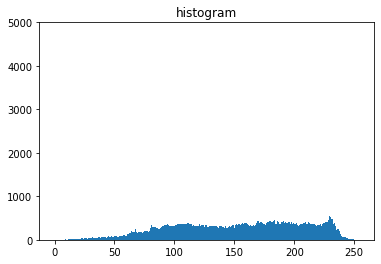

In [ ]:
from matplotlib import pyplot as plt 
import numpy as np
from PIL import Image
im=Image.open("greyscale.png")
f1=open("dat1.txt","w")
pxl=list(im.getdata())

for i in pxl:
    f1.write(str(i)+" ")
    f1.write("\n")

columnsize,rowsize=im.size

a = np.array(pxl)

print(a.shape)
plt.hist(a, bins = 255)
x1,x2,y1,y2 = plt.axis()

plt.axis((x1,x2,0,5000))
plt.title("histogram")
plt.show()

62500
(62500,)


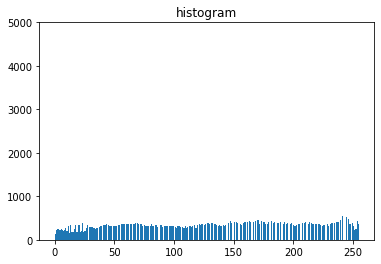

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np
f1=open("dat2.txt","r+")
lines = f1.read().split('\n')
lines.pop()
print(len(lines))

# Convert the pixels into an array using numpy
array = np.array(lines, dtype=np.uint8)

# Use PIL to create an image from the new array of pixels
new_image = Image.fromarray(array.reshape(250,250), 'L')
new_image.save('new.png')

im = Image.open("new.png");
pixel = list(im.getdata())
a=np.array(pixel)
print(a.shape)
plt.hist(a, bins = 255)
x1,x2,y1,y2 = plt.axis()

plt.axis((x1,x2,0,5000))
plt.title("histogram")
plt.show()

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits 

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

In [ ]:
%%cu
#include <stdio.h> 

int main() {
  int nDevices;

  cudaGetDeviceCount(&nDevices);
  for (int i = 0; i < nDevices; i++) {
    cudaDeviceProp prop;
    cudaGetDeviceProperties(&prop, i);
    printf("Device Number: %d\n", i);
    printf("  Device name: %s\n", prop.name);
    printf("  Memory Clock Rate (KHz): %d\n",
           prop.memoryClockRate);
    printf("  Memory Bus Width (bits): %d\n",
           prop.memoryBusWidth);
    printf("  Peak Memory Bandwidth (GB/s): %f\n\n",
           2.0*prop.memoryClockRate*(prop.memoryBusWidth/8)/1.0e6);



           int deviceCount;
cudaGetDeviceCount(&deviceCount);
int device;
for (device = 0; device < deviceCount; ++device) {
    cudaDeviceProp deviceProp;
    cudaGetDeviceProperties(&deviceProp, device);
    printf("Device %d has compute capability %d.%d.\n",
           device, deviceProp.major, deviceProp.minor);
}
  }
}

Device Number: 0
  Device name: Tesla K80
  Memory Clock Rate (KHz): 2505000
  Memory Bus Width (bits): 384
  Peak Memory Bandwidth (GB/s): 240.480000

Device 0 has compute capability 3.7.



In [ ]:
%%cu
#include<cstdlib>
#include<iostream>
using namespace std;
#include<cuda.h>
#include<stdio.h>

__global__ void histogramKernel(int *data,int *bins,long long int N, int N_bins)
{
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(tid<N)
	{
		atomicAdd(&bins[data[tid]],1);
	}
}

__global__ void histogramKernelShared(int *data,int *bins,long long int N, int N_bins, float *binsnew)
{
	extern __shared__ int s_bins[];
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(threadIdx.x < N_bins)s_bins[threadIdx.x]=0;
	__syncthreads();
	if(tid<N)
	{
		atomicAdd(&s_bins[data[tid]],1);
	__syncthreads();
		if(threadIdx.x < N_bins)
	{
			atomicAdd(&bins[threadIdx.x],s_bins[threadIdx.x]);
		__syncthreads();
		__shared__ float s_binsnew[256];
        s_binsnew[threadIdx.x]=0.00;
       for(int i=0;i<=threadIdx.x;i++) s_binsnew[threadIdx.x]+=bins[i];
      __syncthreads();
       s_binsnew[threadIdx.x]=round((s_binsnew[threadIdx.x]/N)*N_bins-1);
			__syncthreads();
       if (s_binsnew[threadIdx.x]>N_bins-1)s_binsnew[threadIdx.x]=N_bins-1;
      __syncthreads();
		binsnew[threadIdx.x] = s_binsnew[threadIdx.x];
	}
	}
}

__global__ void mapHistogram(int *data,long long int N,float *binsnew)
{
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(tid<N)data[tid]=binsnew[data[tid]];
}

void histEq(int *Data, int N, int *bins, int *Data2)
{
		float binsf[256],binsf2[256];
		for(int i=0;i<256;i++){binsf[i]=0;binsf2[i]=0;}

		for(int i=0;i<N;i++)
    	binsf[Data[i]]+=1.0;
		for (int i=0;i<256;i++)
		{
		binsf[i]/=N;

			for(int j=0;j<=i;j++)
			binsf2[i]+=binsf[j];
		bins[i]=(int)round(binsf2[i]*255);
		 
		}
	

		for(int i=0;i<N;i++)
			Data2[i]=bins[Data[i]];
}

void init_array(int *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_arrayf(float *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_long_array(int *a,long long int N,int N_bins)
{
	for(int i=0;i<N;i++)a[i]=rand()%N_bins;
}

void histogram(int *arr, int *bins, long long int N)
{
	for (long long int i=0;i<N;i++)
	{
		bins[arr[i]]++;
	}
}

void print_arr(int *arr, int N)
{
	for (int i=0;i<N;i++)
	{
		//if(arr[i]!=0)
			cout<<i<<"->"<<arr[i]<<endl;
	}
	cout<<endl;
}

void print_arrf(float *arr, int N)
{
	for (int i=0;i<N;i++)
	{
		//if(arr[i]!=0)
			cout<<i<<"->"<<arr[i]<<endl;
	}
	cout<<endl;
}


void print_long_arr(int *arr,long long int N)
{
	for (int i=0;i<N;i++)
	{
		//cout<<"("<<i<<","<<arr[i]<<") ";
		cout<<arr[i]<<" ";
	}
	cout<<endl;
}

void printSum(int *arr,int N)
{
	long long int sum=0;
	for(int i=0;i<N;i++)sum+=arr[i];
	cout<<"Verification of total is: " << sum<<endl;
}

void printSumf(float *arr,int N)
{
	float sum=0.0;
	for(int i=0;i<N;i++)sum+=arr[i];
	cout<<"Verification of total is: " << sum<<endl;
}

int main()
{
	int T=1024,B=1;
	int *Data,N_bins=256,*bins,*Data2;
  bins = (int *)malloc(256*sizeof(int));

	long long int N = 0;
FILE *serTimeEx = fopen("serialTimeExecution.txt","w");
FILE *parTimeEx = fopen("parallelTimeExecution.txt","w");
FILE *speedupEx = fopen("speedup.txt","w");
FILE *exTable = fopen("Execution.txt","w");

	for(N=256;N<134217729;N*=2)
	{
    Data = (int *)malloc(N*sizeof(int));
    Data2 = (int *)malloc(N*sizeof(int));
    init_long_array(Data,N,N_bins);
    init_long_array(Data2,N,N_bins);
		init_array(bins,N_bins);
    B = (N+T-1)/T;
    cudaEvent_t ss,se;
	  float st,st2;

cudaEventCreate(&ss); 
				cudaEventCreate(&se);
				cudaEventRecord(ss);
				cudaDeviceSynchronize();
	        histEq(Data,N,bins,Data2);
				cudaEventRecord(se);
				cudaEventSynchronize(se);
				cudaEventElapsedTime(&st, ss, se);

		int *dev_Data2,*dev_bins2;
		float *dev_bins22,*bins2;
		bins2 = (float *)malloc(N_bins*sizeof(float));

		init_arrayf(bins2,N_bins);
		cudaMalloc((void**)&dev_Data2,N*sizeof(int));
		cudaMalloc((void**)&dev_bins2,N_bins*sizeof(int));
		cudaMalloc((void**)&dev_bins22,N_bins*sizeof(float));

		cudaMemcpy(dev_Data2, Data , N*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins2, bins , N_bins*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins22, bins2 , N_bins*sizeof(float),cudaMemcpyHostToDevice);

		cudaEventCreate(&ss); 
					cudaEventCreate(&se);
					cudaEventRecord(ss);
					cudaDeviceSynchronize();
		
						histogramKernelShared<<<B,T,N_bins*sizeof(int)>>>(dev_Data2,dev_bins2,N,N_bins,dev_bins22);
						mapHistogram<<<B,T>>>(dev_Data2,N,dev_bins22);

					cudaEventRecord(se);
					cudaEventSynchronize(se);
					cudaEventElapsedTime(&st2, ss, se);
		
cout<<N<<"  "<<st<<" "<<st2<<" "<<st/st2<<endl;


fprintf(serTimeEx,"%d\t%f\n",N,st);
fprintf(parTimeEx,"%d\t%f\n",N,st2);
fprintf(speedupEx,"%d\t%f\n",N,st/st2);
fprintf(exTable,"%d\t%f\t%f\t%f\n",N,st,st2,st/st2);

		cudaMemcpy(bins,dev_bins2,N_bins*sizeof(int),cudaMemcpyDeviceToHost);
		cudaMemcpy(bins2,dev_bins22,N_bins*sizeof(float),cudaMemcpyDeviceToHost);
		cudaMemcpy(Data,dev_Data2,N*sizeof(int),cudaMemcpyDeviceToHost);
  
		cudaFree(dev_Data2);cudaFree(dev_bins2);cudaFree(dev_bins22);
		free(bins2);
	}
  fclose(serTimeEx);fclose(parTimeEx);fclose(speedupEx);fclose(exTable);
	free(Data);free(bins);
	return 0;
}

256  0.121888 0.144544 0.843259
512  0.123648 0.06672 1.85324
1024  0.1296 0.06528 1.98529
2048  0.133184 0.067904 1.96136
4096  0.145664 0.070016 2.08044
8192  0.172608 0.071744 2.40589
16384  0.223936 0.079904 2.80256
32768  0.33584 0.114304 2.93813
65536  0.546048 0.172384 3.16763
131072  0.963584 0.263136 3.66192
262144  1.82 0.455584 3.99487
524288  3.50323 0.85024 4.12029
1048576  7.19626 1.6168 4.45093
2097152  14.2122 3.14346 4.52119
4194304  27.9899 6.18944 4.5222
8388608  55.6754 12.2732 4.53634
16777216  135.165 24.451 5.52801
33554432  225.846 48.7902 4.62891
67108864  460.097 97.5247 4.71775
134217728  896.339 167.731 5.34391



In [ ]:
%%cu
#include<cstdlib>
#include<iostream>
using namespace std;
#include<cuda.h>
#include<stdio.h>

__global__ void histogramKernel(int *data,int *bins,long long int N, int N_bins)
{
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(tid<N)
	{
		atomicAdd(&bins[data[tid]],1);
	}
  for(int i=0;i<100000;i++){}
}

__global__ void histogramKernelShared(int *data,int *bins,long long int N, int N_bins, float *binsnew)
{
	extern __shared__ int s_bins[];
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(threadIdx.x < N_bins)s_bins[threadIdx.x]=0;
	__syncthreads();
	if(tid<N)
	{
		atomicAdd(&s_bins[data[tid]],1);
	__syncthreads();
		if(threadIdx.x < N_bins)
	  {
			atomicAdd(&bins[threadIdx.x],s_bins[threadIdx.x]);
    }
	}
}

void print_arr(int *arr, int N)
{
	for (int i=0;i<N;i++)
	{
		//if(arr[i]!=0)
			cout<<i<<"->"<<arr[i]<<endl;
	}
	cout<<endl;
}

void init_array(int *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_arrayf(float *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_long_array(int *a,long long int N,int N_bins)
{
	for(int i=0;i<N;i++)a[i]=rand()%N_bins;
}




int main()
{
	int T=1024,B=1;
	int *Data,N_bins=256,*bins,*Data2;
  bins = (int *)malloc(N_bins*sizeof(int));

	long long int N = 0;
FILE *shaHistEx = fopen("sharedHistogramExecution.txt","w");
FILE *gloHistEx = fopen("globalHistogramExecution.txt","w");

	for(N=256;N<134217729;N*=2)//134217729
	{
    Data = (int *)malloc(N*sizeof(int));
    Data2 = (int *)malloc(N*sizeof(int));
    init_long_array(Data,N,N_bins);
    init_long_array(Data2,N,N_bins);
		init_array(bins,N_bins);
    B = (N+T-1)/T;
    cudaEvent_t ss,se;
	  float st,st2;
 int *dev_Data,*dev_bins;
		cudaMalloc((void**)&dev_Data,N*sizeof(int));
		cudaMalloc((void**)&dev_bins,N_bins*sizeof(int));
		cudaMemcpy(dev_Data, Data , N*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins, bins , N_bins*sizeof(int),cudaMemcpyHostToDevice);
cudaEventCreate(&ss); 
				cudaEventCreate(&se);
				cudaEventRecord(ss);
				cudaDeviceSynchronize();
	        histogramKernel<<<B,T>>>(dev_Data,dev_bins,N,N_bins);
				cudaEventRecord(se);
				cudaEventSynchronize(se);
				cudaEventElapsedTime(&st, ss, se);
    cudaMemcpy(bins,dev_bins,N_bins*sizeof(int),cudaMemcpyDeviceToHost);
		cudaMemcpy(Data,dev_Data,N*sizeof(int),cudaMemcpyDeviceToHost);
cudaFree(dev_Data);cudaFree(dev_bins);
		int *dev_Data2,*dev_bins2;
		float *dev_bins22,*bins2;
		bins2 = (float *)malloc(N_bins*sizeof(float));
		init_array(bins,N_bins);
		init_arrayf(bins2,N_bins);
  
		cudaMalloc((void**)&dev_Data2,N*sizeof(int));
		cudaMalloc((void**)&dev_bins2,N_bins*sizeof(int));
		cudaMalloc((void**)&dev_bins22,N_bins*sizeof(float));

		cudaMemcpy(dev_Data2, Data , N*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins2, bins , N_bins*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins22, bins2 , N_bins*sizeof(float),cudaMemcpyHostToDevice);

		cudaEventCreate(&ss); 
					cudaEventCreate(&se);
					cudaEventRecord(ss);
					cudaDeviceSynchronize();
		
						histogramKernelShared<<<B,T,N_bins*sizeof(int)>>>(dev_Data2,dev_bins2,N,N_bins,dev_bins22);

					cudaEventRecord(se);
					cudaEventSynchronize(se);
					cudaEventElapsedTime(&st2, ss, se);
		
cout<<N<<"  "<<st<<" "<<st2<<" "<<st/st2<<endl;

fprintf(shaHistEx,"%d\t%f\n",N,st2);
fprintf(gloHistEx,"%d\t%f\n",N,st);
		cudaMemcpy(bins,dev_bins2,N_bins*sizeof(int),cudaMemcpyDeviceToHost);
		cudaMemcpy(bins2,dev_bins22,N_bins*sizeof(float),cudaMemcpyDeviceToHost);
		cudaMemcpy(Data,dev_Data2,N*sizeof(int),cudaMemcpyDeviceToHost);
  
		cudaFree(dev_Data2);cudaFree(dev_bins2);cudaFree(dev_bins22);
		free(bins2);
	}
  fclose(shaHistEx);fclose(gloHistEx);
	free(Data);free(bins);
	return 0;
}

256  0.088512 0.03248 2.72512
512  0.027968 0.029888 0.93576
1024  0.025248 0.02912 0.867033
2048  0.028608 0.030592 0.935146
4096  0.028416 0.0304 0.934737
8192  0.030304 0.030496 0.993704
16384  0.028736 0.031168 0.921971
32768  0.0336 0.033312 1.00865
65536  0.03936 0.039072 1.00737
131072  0.05056 0.050688 0.997475
262144  0.076 0.072224 1.05228
524288  0.122336 0.119008 1.02796
1048576  0.222432 0.208992 1.06431
2097152  0.397632 0.380544 1.0449
4194304  0.74336 0.72896 1.01975
8388608  1.47098 1.43933 1.02199
16777216  2.89955 2.83942 1.02118
33554432  5.75715 5.63216 1.02219
67108864  11.2612 11.2263 1.0031
134217728  20.1928 15.7017 1.28603



In [ ]:
%%cu
#include<cstdlib>
#include<iostream>
using namespace std;
#include<cuda.h>
#include<stdio.h>

__global__ void histogramKernelShared(int *data,int *bins,long long int N, int N_bins, float *binsnew)
{
	extern __shared__ int s_bins[];
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(threadIdx.x < N_bins)s_bins[threadIdx.x]=0;
	__syncthreads();
	if(tid<N)
	{
		atomicAdd(&s_bins[data[tid]],1);
	__syncthreads();
		if(threadIdx.x < N_bins)
	{
			atomicAdd(&bins[threadIdx.x],s_bins[threadIdx.x]);
		__syncthreads();
		__shared__ float s_binsnew[256];
        s_binsnew[threadIdx.x]=0.00;
       for(int i=0;i<=threadIdx.x;i++) s_binsnew[threadIdx.x]+=bins[i];
      __syncthreads();
       s_binsnew[threadIdx.x]=round((s_binsnew[threadIdx.x]/N)*N_bins-1);
			__syncthreads();
       if (s_binsnew[threadIdx.x]>N_bins-1)s_binsnew[threadIdx.x]=N_bins-1;
      __syncthreads();
		binsnew[threadIdx.x] = s_binsnew[threadIdx.x];
	}
	}
}

__global__ void mapHistogram(int *data,long long int N,float *binsnew)
{
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(tid<N)data[tid]=binsnew[data[tid]];
}


void init_array(int *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_arrayf(float *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_long_array(int *a,long long int N,int N_bins)
{
	for(int i=0;i<N;i++)a[i]=rand()%N_bins;
}


int main()
{
	int T=1024,B=1;
	int *Data,N_bins=256,*bins,*Data2;
  bins = (int *)malloc(256*sizeof(int));
FILE *totalParTime = fopen("totalPar.txt","w");
	long long int N = 0;

	for(N=256;N<134217729;N*=2)//134217729
	{
    Data = (int *)malloc(N*sizeof(int));
    Data2 = (int *)malloc(N*sizeof(int));
    init_long_array(Data,N,N_bins);
    init_long_array(Data2,N,N_bins);
		init_array(bins,N_bins);
    B = (N+T-1)/T;
    cudaEvent_t ss,se;
	  float st,st2,st3;

		int *dev_Data2,*dev_bins2;
		float *dev_bins22,*bins2;
		bins2 = (float *)malloc(N_bins*sizeof(float));

		init_arrayf(bins2,N_bins);
		cudaMalloc((void**)&dev_Data2,N*sizeof(int));
		cudaMalloc((void**)&dev_bins2,N_bins*sizeof(int));
		cudaMalloc((void**)&dev_bins22,N_bins*sizeof(float));

cudaEventCreate(&ss); 
					cudaEventCreate(&se);
					cudaEventRecord(ss);
					cudaDeviceSynchronize();
		cudaMemcpy(dev_Data2, Data , N*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins2, bins , N_bins*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins22, bins2 , N_bins*sizeof(float),cudaMemcpyHostToDevice);
cudaEventRecord(se);
cudaEventSynchronize(se);
cudaEventElapsedTime(&st, ss, se);
		

    cudaEventCreate(&ss); 
					cudaEventCreate(&se);
					cudaEventRecord(ss);
					cudaDeviceSynchronize();
						histogramKernelShared<<<B,T,N_bins*sizeof(int)>>>(dev_Data2,dev_bins2,N,N_bins,dev_bins22);
						mapHistogram<<<B,T>>>(dev_Data2,N,dev_bins22);
cudaEventRecord(se);
cudaEventSynchronize(se);
cudaEventElapsedTime(&st3, ss, se);
		
cudaEventCreate(&ss); 
					cudaEventCreate(&se);
					cudaEventRecord(ss);
					cudaDeviceSynchronize();
		cudaMemcpy(bins,dev_bins2,N_bins*sizeof(int),cudaMemcpyDeviceToHost);
		cudaMemcpy(bins2,dev_bins22,N_bins*sizeof(float),cudaMemcpyDeviceToHost);
		cudaMemcpy(Data,dev_Data2,N*sizeof(int),cudaMemcpyDeviceToHost);
    
cudaEventRecord(se);
cudaEventSynchronize(se);
cudaEventElapsedTime(&st2, ss, se);

  cout<<N<<"  "<<st<<" "<<st2<<" "<<st3<<" "<<st+st2+st3<<endl;
fprintf(totalParTime,"%d  %f  %f  %f  %f\n",N,st,st2,st3,st+st2+st3);
		cudaFree(dev_Data2);cudaFree(dev_bins2);cudaFree(dev_bins22);
		free(bins2);
	}
 fclose(totalParTime);
	free(Data);free(bins);
	return 0;
}

256  0.043456 0.062304 0.126944 0.232704
512  0.043744 0.049696 0.0632 0.15664
1024  0.041984 0.068256 0.06592 0.17616
2048  0.040032 0.050496 0.072704 0.163232
4096  0.049248 0.05248 0.068704 0.170432
8192  0.056032 0.087648 0.0712 0.21488
16384  0.069472 0.067328 0.079616 0.216416
32768  0.077152 0.084672 0.114912 0.276736
65536  0.11568 0.124 0.165024 0.404704
131072  0.1984 0.226432 0.264 0.688832
262144  0.365408 0.340864 0.466848 1.17312
524288  0.48864 0.535616 0.852704 1.87696
1048576  0.78256 0.71184 1.62576 3.12016
2097152  1.512 1.2703 3.16038 5.94269
4194304  2.51846 2.34032 6.23779 11.0966
8388608  4.69661 4.61312 12.3779 21.6876
16777216  9.23539 8.80758 24.6647 42.7077
33554432  18.1441 17.5052 49.2543 84.9035
67108864  36.2116 31.1667 97.549 164.927
134217728  71.0009 56.9725 175.489 303.463



In [ ]:
%%cu
#include<cstdlib>
#include<iostream>
using namespace std;
#include<cuda.h>
#include<stdio.h>

__global__ void histogramKernel(int *data,int *bins,long long int N, int N_bins)
{
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(tid<N)
	{
		atomicAdd(&bins[data[tid]],1);
	}
  for(int i=0;i<100000;i++){}
}

__global__ void histogramKernelShared(int *data,int *bins,long long int N, int N_bins, float *binsnew)
{
	extern __shared__ int s_bins[];
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(threadIdx.x < N_bins)s_bins[threadIdx.x]=0;
	__syncthreads();
	if(tid<N)
	{
		atomicAdd(&s_bins[data[tid]],1);
	__syncthreads();
		if(threadIdx.x < N_bins)
	  {
			atomicAdd(&bins[threadIdx.x],s_bins[threadIdx.x]);
    }
	}
}

void print_arr(int *arr, int N)
{
	for (int i=0;i<N;i++)
	{
		//if(arr[i]!=0)
			cout<<i<<"->"<<arr[i]<<endl;
	}
	cout<<endl;
}

void init_array(int *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_arrayf(float *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_long_array(int *a,long long int N,int N_bins)
{
	for(int i=0;i<N;i++)a[i]=255;
}

int main()
{
	int T=1024,B=1;
	int *Data,N_bins=256,*bins,*Data2;
  bins = (int *)malloc(N_bins*sizeof(int));

	long long int N = 0;
FILE *sha_gloHistEx = fopen("shared-globalHistogramExecutionBest.txt","w");

	for(N=256;N<134217729;N*=2)//134217729
	{
			cout<<"N is "<<N<<endl;
    Data = (int *)malloc(N*sizeof(int));
    Data2 = (int *)malloc(N*sizeof(int));
    init_long_array(Data,N,N_bins);
    init_long_array(Data2,N,N_bins);
		init_array(bins,N_bins);
    B = (N+T-1)/T;
    cudaEvent_t ss,se;
	  float st,st2;
 int *dev_Data,*dev_bins;
		cudaMalloc((void**)&dev_Data,N*sizeof(int));
		cudaMalloc((void**)&dev_bins,N_bins*sizeof(int));
		cudaMemcpy(dev_Data, Data , N*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins, bins , N_bins*sizeof(int),cudaMemcpyHostToDevice);
cudaEventCreate(&ss); 
				cudaEventCreate(&se);
				cudaEventRecord(ss);
				cudaDeviceSynchronize();
	        histogramKernel<<<B,T>>>(dev_Data,dev_bins,N,N_bins);
				cudaEventRecord(se);
				cudaEventSynchronize(se);
				cudaEventElapsedTime(&st, ss, se);
    cudaMemcpy(bins,dev_bins,N_bins*sizeof(int),cudaMemcpyDeviceToHost);
		cudaMemcpy(Data,dev_Data,N*sizeof(int),cudaMemcpyDeviceToHost);
		
cudaFree(dev_Data);cudaFree(dev_bins);
		int *dev_Data2,*dev_bins2;
		float *dev_bins22,*bins2;
		bins2 = (float *)malloc(N_bins*sizeof(float));
		init_array(bins,N_bins);
		init_arrayf(bins2,N_bins);
  
		cudaMalloc((void**)&dev_Data2,N*sizeof(int));
		cudaMalloc((void**)&dev_bins2,N_bins*sizeof(int));
		cudaMalloc((void**)&dev_bins22,N_bins*sizeof(float));

		cudaMemcpy(dev_Data2, Data , N*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins2, bins , N_bins*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins22, bins2 , N_bins*sizeof(float),cudaMemcpyHostToDevice);

		cudaEventCreate(&ss); 
					cudaEventCreate(&se);
					cudaEventRecord(ss);
					cudaDeviceSynchronize();
		
						histogramKernelShared<<<B,T,N_bins*sizeof(int)>>>(dev_Data2,dev_bins2,N,N_bins,dev_bins22);

					cudaEventRecord(se);
					cudaEventSynchronize(se);
					cudaEventElapsedTime(&st2, ss, se);
		
cout<<N<<"  "<<st2<<" "<<st<<" "<<st/st2<<endl;

fprintf(sha_gloHistEx,"%10d %10f %10f\n",N,st2,st);

		cudaMemcpy(bins,dev_bins2,N_bins*sizeof(int),cudaMemcpyDeviceToHost);
		cudaMemcpy(bins2,dev_bins22,N_bins*sizeof(float),cudaMemcpyDeviceToHost);
		cudaMemcpy(Data,dev_Data2,N*sizeof(int),cudaMemcpyDeviceToHost);
  
		cudaFree(dev_Data2);cudaFree(dev_bins2);cudaFree(dev_bins22);
		free(bins2);
	}
  fclose(sha_gloHistEx);
	free(Data);free(bins);
	return 0;
}

N is 256
256  0.067488 0.083232 1.23329
N is 512
512  0.0896 0.027776 0.31
N is 1024
1024  0.115584 0.028672 0.248062
N is 2048
2048  0.119424 0.0312 0.261254
N is 4096
4096  0.116576 0.03568 0.306066
N is 8192
8192  0.118432 0.04112 0.347203
N is 16384
16384  0.153952 0.08592 0.558096
N is 32768
32768  0.244576 0.089664 0.36661
N is 65536
65536  0.38848 0.152064 0.391433
N is 131072
131072  0.644288 0.27376 0.424903
N is 262144
262144  1.24042 0.51952 0.418827
N is 524288
524288  2.45949 1.01232 0.411598
N is 1048576
1048576  4.84058 1.99798 0.412757
N is 2097152
2097152  9.63344 3.96419 0.411503
N is 4194304
4194304  19.1832 7.88938 0.411264
N is 8388608
8388608  38.3437 15.7485 0.41072
N is 16777216
16777216  76.6161 31.5064 0.411225
N is 33554432
33554432  141.283 57.5679 0.407466
N is 67108864
67108864  219.786 104.11 0.473689
N is 134217728
134217728  400.688 161.567 0.403223



In [ ]:
%%cu
#include<cstdlib>
#include<iostream>
#include<cuda.h>
#include<stdio.h>
using namespace std;

__global__ void histogramKernelShared(int *data,int *bins,long long int N, int N_bins, float *binsnew)
{
	extern __shared__ int s_bins[];
	int tid = blockIdx.x*blockDim.x+threadIdx.x;
	if(threadIdx.x < N_bins)s_bins[threadIdx.x]=0;
	__syncthreads();
	if(tid<N)
	{
		atomicAdd(&s_bins[data[tid]],1);
	__syncthreads();
		if(threadIdx.x < N_bins)
	  {
			atomicAdd(&bins[threadIdx.x],s_bins[threadIdx.x]);
    }
	}
}

void histCreate(int *Data, long long int N, int *bins)
{
    for(int i=0;i<N;i++)
      bins[Data[i]]+=1;
}

void print_arr(int *arr, int N)
{
	for (int i=0;i<N;i++)
	{
		//if(arr[i]!=0)
			cout<<i<<"->"<<arr[i]<<endl;
	}
	cout<<endl;
}

void init_array(int *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_arrayf(float *a, int N)
{
	for(int i=0;i<N;i++)a[i]=0;
}

void init_long_array(int *a,long long int N,int N_bins)
{
	for(int i=0;i<N;i++)a[i]=rand()%N_bins;
}

int main()
{
	int T=1024,B=1;
	int *Data,N_bins=256,*bins,*Data2;
  bins = (int *)malloc(N_bins*sizeof(int));

	long long int N = 0;
FILE *histSer = fopen("histSer.txt","w");
FILE *histPar = fopen("histPar.txt","w");
FILE *speedHist = fopen("speedHist.txt","w");

	for(N=256;N<134217729;N*=2)//134217729
	{
			cout<<"N is "<<N<<endl;
    Data = (int *)malloc(N*sizeof(int));
    Data2 = (int *)malloc(N*sizeof(int));
    init_long_array(Data,N,N_bins);
    init_long_array(Data2,N,N_bins);
		init_array(bins,N_bins);
    B = (N+T-1)/T;
    cudaEvent_t ss,se;
	  float st,st2;

cudaEventCreate(&ss); 
				cudaEventCreate(&se);
				cudaEventRecord(ss);
				cudaDeviceSynchronize();
           histCreate(Data,N,bins);
				cudaEventRecord(se);
				cudaEventSynchronize(se);
				cudaEventElapsedTime(&st, ss, se);
		
		int *dev_Data2,*dev_bins2;
		float *dev_bins22,*bins2;
		bins2 = (float *)malloc(N_bins*sizeof(float));
		init_array(bins,N_bins);
		init_arrayf(bins2,N_bins);
  
		cudaMalloc((void**)&dev_Data2,N*sizeof(int));
		cudaMalloc((void**)&dev_bins2,N_bins*sizeof(int));
		cudaMalloc((void**)&dev_bins22,N_bins*sizeof(float));

		cudaMemcpy(dev_Data2, Data , N*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins2, bins , N_bins*sizeof(int),cudaMemcpyHostToDevice);
		cudaMemcpy(dev_bins22, bins2 , N_bins*sizeof(float),cudaMemcpyHostToDevice);

		cudaEventCreate(&ss); 
					cudaEventCreate(&se);
					cudaEventRecord(ss);
					cudaDeviceSynchronize();
		
						histogramKernelShared<<<B,T,N_bins*sizeof(int)>>>(dev_Data2,dev_bins2,N,N_bins,dev_bins22);

					cudaEventRecord(se);
					cudaEventSynchronize(se);
					cudaEventElapsedTime(&st2, ss, se);
		
cout<<N<<"  "<<st<<" "<<st2<<" "<<st/st2<<endl;

fprintf(histSer,"%d\t%f\n",N,st);
fprintf(histPar,"%d\t%f\n",N,st2);
fprintf(speedHist,"%d\t%f\n",N,st/st2);


		cudaMemcpy(bins,dev_bins2,N_bins*sizeof(int),cudaMemcpyDeviceToHost);
		cudaMemcpy(bins2,dev_bins22,N_bins*sizeof(float),cudaMemcpyDeviceToHost);
		cudaMemcpy(Data,dev_Data2,N*sizeof(int),cudaMemcpyDeviceToHost);
  
		cudaFree(dev_Data2);cudaFree(dev_bins2);cudaFree(dev_bins22);
		free(bins2);
	}
  fclose(histSer);fclose(histPar);fclose(speedHist);
	free(Data);free(bins);
	return 0;
}

N is 256
256  0.01616 0.113536 0.142334
N is 512
512  0.01744 0.03392 0.514151
N is 1024
1024  0.02368 0.036064 0.65661
N is 2048
2048  0.026784 0.037696 0.710526
N is 4096
4096  0.026208 0.031168 0.840862
N is 8192
8192  0.040288 0.033056 1.21878
N is 16384
16384  0.111872 0.033472 3.34226
N is 32768
32768  0.123328 0.034816 3.54228
N is 65536
65536  0.273888 0.04912 5.5759
N is 131072
131072  0.464352 0.050272 9.23679
N is 262144
262144  0.91296 0.072384 12.6127
N is 524288
524288  1.90141 0.118944 15.9857
N is 1048576
1048576  3.60749 0.208192 17.3277
N is 2097152
2097152  7.2704 0.388896 18.695
N is 4194304
4194304  15.0612 0.741536 20.3108
N is 8388608
8388608  30.2629 1.4409 21.0028
N is 16777216
16777216  61.779 2.83926 21.7588
N is 33554432
33554432  119.886 5.63501 21.2751
N is 67108864
67108864  237.075 11.222 21.1258
N is 134217728
134217728  483.701 22.4185 21.5759

